# Latent representation analysis
In this notebook we analyse and compare the latent representations produced by the Wav2Vec2 feature extractor and the brain feature extractor

## Preperation

### Imports

In [1]:
from src.args.base_args import B2TDatasetArgsModel
from src.datasets.brain2text_w_phonemes import Brain2TextWPhonemesDataset
from src.analysis.latent_analysis_util import generate_speech_multiple, generate_audio_representations, generate_brain_representations
import torch
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from src.args.yaml_config import YamlConfig
yaml_config = YamlConfig().config

/hpi/fs00/home/tobias.fiedler/miniconda3/envs/b2t/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Extract test transcriptions

In [2]:
test_ds = Brain2TextWPhonemesDataset(B2TDatasetArgsModel(limit_samples=10), yaml_config, "test")
test_transcriptions = [test_ds[i].transcription for i in range(len(test_ds))]

### Generate speech for test transcriptions

In [3]:
generate_speech_multiple(test_transcriptions)

10/10 audios generated (0 newly generated)



## Generate audio latent representations

In [4]:
audio_representations = generate_audio_representations(test_ds) 

10/10 audio representations generated 



## Generate brain latent representations

In [5]:
brain_representations = generate_brain_representations(test_ds)

/hpi/fs00/home/tobias.fiedler/miniconda3/envs/b2t/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1699449183005/work/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/hpi/fs00/home/tobias.fiedler/brain2text/src/model/b2p2t_model.py:90: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /opt/conda/conda-bld/pytorch_1699449183005/work/aten/src/ATen/native/Convolution.cpp:1008.)
  return self.conv(input, weight=self.weight, groups=self.groups, padding="same")


10/10 brain representations generated 



## Perform Dimensionality reduction

In [7]:
all_data = audio_representations.non_aggregated + brain_representations.non_aggregated
all_data_np = torch.stack([rep for _, rep in all_data]).numpy()
dim_reducer = TSNE(n_components=2)
all_data_dimreduced = dim_reducer.fit_transform(all_data_np)

### Visualize audio / brain encoder clusters (no seq aggregation)

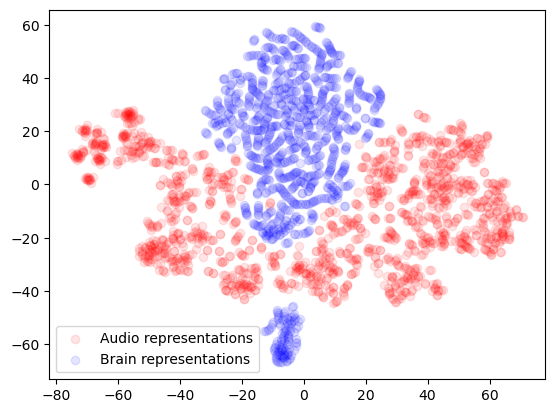

In [8]:
# Show scatter plot of all_data_pca with the first len(test_set) samples in one color and the rest in another color
plt.scatter(all_data_dimreduced[:len(audio_representations.non_aggregated), 0], all_data_dimreduced[:len(audio_representations.non_aggregated), 1], c="red", label="Audio representations", alpha=0.1)
plt.scatter(all_data_dimreduced[len(audio_representations.non_aggregated):, 0], all_data_dimreduced[len(audio_representations.non_aggregated):, 1], c="blue", label="Brain representations", alpha=0.1)
plt.legend()
plt.show()

### Visualize audio / brain encoder clusters (with seq aggregation)

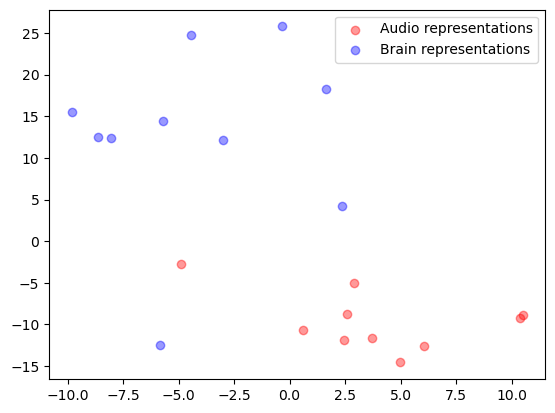

In [9]:
seq_dimreduced_avg = []
i=0
while i <(len(all_data_dimreduced)):
    j = i+1
    idx = all_data[i].idx
    while j<len(all_data_dimreduced) and all_data[j].idx == idx:
        j+=1
    seq_dimreduced_avg.append(np.mean(all_data_dimreduced[i:j], axis=0))
    i = j 
    
assert len(seq_dimreduced_avg) == len(test_ds) * 2, f"Expected {len(test_ds) * 2} sequences, got {len(seq_dimreduced_avg)}"
seq_dimreduced_avg_np = np.array(seq_dimreduced_avg)
plt.scatter(seq_dimreduced_avg_np[:len(test_ds), 0], seq_dimreduced_avg_np[:len(test_ds), 1], c="red", label="Audio representations", alpha=0.4)
plt.scatter(seq_dimreduced_avg_np[len(test_ds):, 0], seq_dimreduced_avg_np[len(test_ds):, 1], c="blue", label="Brain representations", alpha=0.4)
plt.legend()
plt.show()

### Visualize sample pairs (brain, audio)

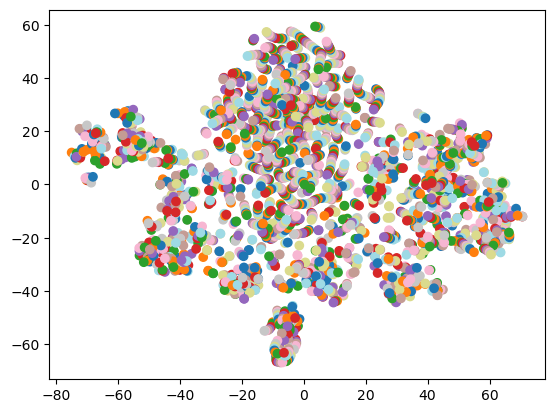

In [10]:
# Show scatter plot with each index modulo len(test_set) in one color

plt.scatter(all_data_dimreduced[:, 0], all_data_dimreduced[:, 1], c=[i % len(test_ds) for i in range(len(all_data_dimreduced))], cmap="tab20") #type: ignore

## Distance between dimensionality reduced audio and brain representation pairs

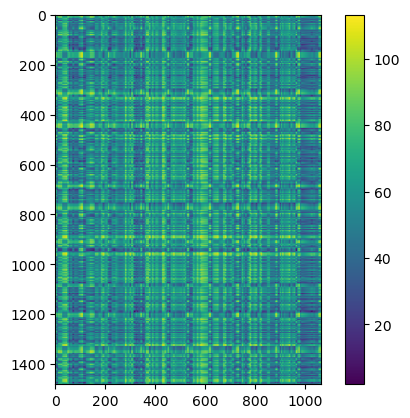

In [12]:
# Show distance matrix between dimensionality reduced audio and brain representation pairs
from scipy.spatial.distance import cdist

dimreduced_distances = cdist(all_data_dimreduced[:len(audio_representations.non_aggregated)], all_data_dimreduced[len(audio_representations.non_aggregated):],'euclidean')
plt.imshow(dimreduced_distances)
plt.colorbar()

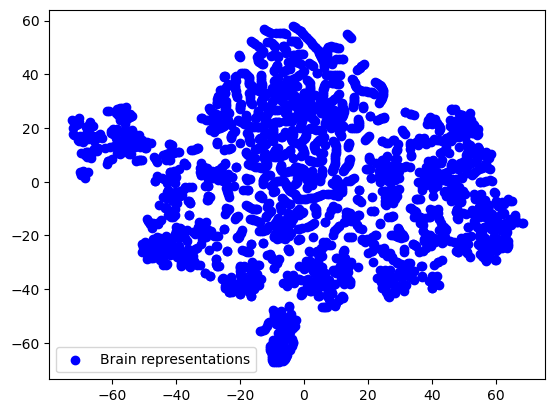

In [12]:
brain_dim_reducer =TSNE(n_components=2) #PCA(n_components=2)
brain_data_dimreduced = brain_dim_reducer.fit_transform(all_data_np[len(test_ds):])
plt.scatter(brain_data_dimreduced[:, 0], brain_data_dimreduced[:, 1], c="blue", label="Brain representations")
plt.legend()
plt.show()

## Transcription phoneme distance matrix

100% of distances calculated 

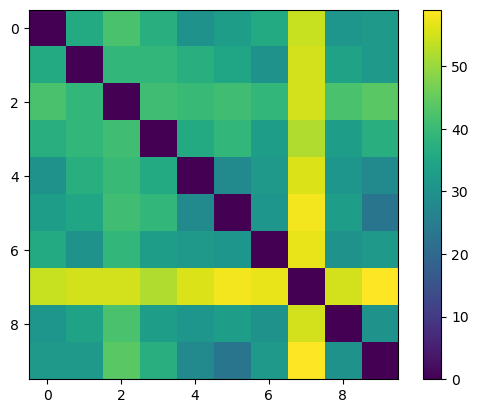

In [13]:
from edit_distance import SequenceMatcher

test_phonemes = [test_ds[i].phonemes for i in range(len(test_ds))]

label_distances = np.zeros((len(test_phonemes), len(test_phonemes)))
for i in range(len(test_phonemes)):
    for j in range(len(test_phonemes)):
        matcher = SequenceMatcher(a=test_phonemes[i], b=test_phonemes[j])
        dist = matcher.distance()
        label_distances[i][j] = dist
    print(f"\r{int(((i+1)/len(test_transcriptions))*100)}% of distances calculated ", end="")
plt.imshow(label_distances, interpolation="nearest")
plt.colorbar()

### Compute correlation between phoneme transcription distance and brain representation distance

In [14]:
np.correlate(label_distances.flatten(), cdist(brain_data_dimreduced, brain_data_dimreduced).flatten())

array([173502.92944882, 176574.63106979, 179408.13549888, ...,
       299530.29567133, 299142.40128944, 291810.11942196])

### Relationship between transcription phoneme distance and brain representation pairs distance

ValueError: x and y must be the same size

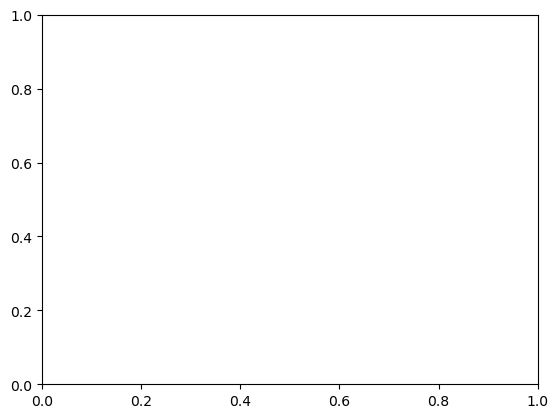

In [15]:
plt.scatter(label_distances.flatten(), cdist(brain_data_dimreduced, brain_data_dimreduced).flatten(), alpha=0.1)
plt.xlabel("Phoneme distance")
plt.ylabel("Brain representation distance")
plt.show()

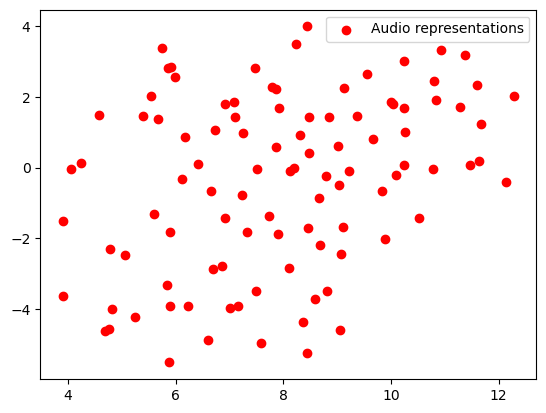

In [ ]:
audio_only_dimreducer = TSNE(n_components=2)#PCA(n_components=2)
audio_data_dimreduced = audio_only_dimreducer.fit_transform(all_data_np[:len(test_ds)])
plt.scatter(audio_data_dimreduced[:, 0], audio_data_dimreduced[:, 1], c="red", label="Audio representations")
plt.legend()
plt.show()

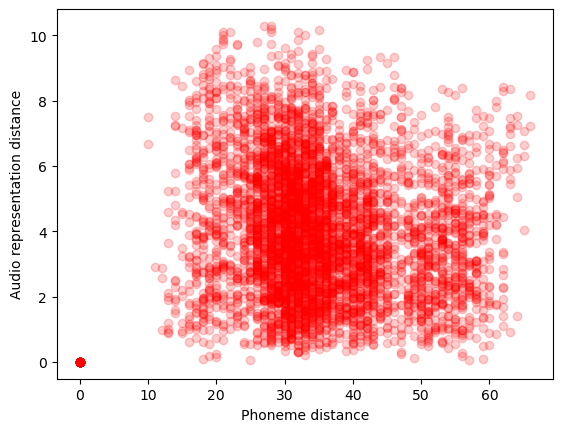

In [ ]:
plt.scatter(label_distances.flatten(), cdist(audio_data_dimreduced, audio_data_dimreduced).flatten(), c="red", alpha=0.1)
plt.xlabel("Phoneme distance")
plt.ylabel("Audio representation distance")
plt.show()